In [1]:
from torchvision import models
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from imageio import imread
from skimage.color import rgb2gray, gray2rgb
import cv2
from skimage.feature import canny
import torchvision.transforms.functional as F

# Model

In [2]:
import torch
from src.models import EdgeModel, InpaintingModel
from load_config import load_config

In [3]:
config = load_config()
config.DEVICE = torch.device("cpu")

------------ Options -------------
INPUT_SIZE: 256
TEST_FLIST: ./Images/Inputs
RESULTS: ./Images/Outputs
MODE: 2
MODEL: 3
OBJECTS: [3, 15]
SEG_DEVICE: cpu
INPUT_SIZE: 256
-------------- End ----------------


In [4]:
edge_model = EdgeModel(config).to(config.DEVICE)
inpaint_model = InpaintingModel(config).to(config.DEVICE)

In [5]:
edge_model.load()
inpaint_model.load()

Loading EdgeModel generator...
Loading InpaintingModel generator...


In [6]:
edge_model.eval()

EdgeModel(
  (generator): EdgeGenerator(
    (encoder): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (9): ReLU(inplace=True)
    )
    (middle): Sequential(
      (0): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((2, 2, 2, 2))
          (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2), bias=False)
          (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, aff

In [7]:
inpaint_model.eval()

InpaintingModel(
  (generator): InpaintGenerator(
    (encoder): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1))
      (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (9): ReLU(inplace=True)
    )
    (middle): Sequential(
      (0): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((2, 2, 2, 2))
          (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2))
          (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine

# Load Data

In [8]:
from src.segmentor_fcn import decode_segmap, fill_gaps, fill_gaps2, remove_patch_og, segmentor

In [9]:
def to_tensor(img):
    img = Image.fromarray(img)
    img_t = F.to_tensor(img).float()
    #img_t = torch.from_numpy(np.array(img, np.float32, copy=False))
    return img_t

In [10]:
def load_edge(img, mask):
    sigma = 2

    # in test mode images are masked (with masked regions),
    # using 'mask' parameter prevents canny to detect edges for the masked regions
    mask = None
        
    # canny
    # no edge
    if sigma == -1:
        return np.zeros(img.shape).astype(np.float)

    # random sigma
    if sigma == 0:
        sigma = random.randint(1, 4)

    return canny(img, sigma=sigma, mask=mask).astype(np.float)

In [11]:
def load(path_img, input_size, segment_net, device, objects):
    img = Image.open(path_img)
    #Create_img and mask
    img,mask=segmentor(segment_net, img, device, objects)
    #Resize image
    img = Image.fromarray(img)
    img = np.array(img.resize((input_size, input_size), Image.ANTIALIAS))
    # create grayscale image
    img_gray = rgb2gray(np.array(img))
    #Resize mask
    mask = Image.fromarray(mask)
    mask = np.array(mask.resize((input_size, input_size), Image.ANTIALIAS))
    idx=(mask>0)
    mask[idx]=255
    mask=np.apply_along_axis(fill_gaps, 1, mask) #horizontal padding
    mask=np.apply_along_axis(fill_gaps, 0, mask) #vertical padding

    # load edge
    edge = load_edge(img_gray, mask)

    # augment data
    #img = img[:, ::-1, ...]
    #img_gray = img_gray[:, ::-1, ...]
    #edge = edge[:, ::-1, ...]
    #mask = mask[:, ::-1, ...]

    img_input = to_tensor(img)
    img_gray_input = to_tensor(img_gray)
    edge_input = to_tensor(edge)
    mask_input = to_tensor(mask)
    return img_input, img_gray_input, edge_input, mask_input

# Test

In [12]:
def postprocess(img):
    # [0, 1] => [0, 255]
    img = img * 255.0
    img = img.permute(0, 2, 3, 1)
    return img.int()

In [13]:
def load_size(path_img):
    img = Image.open(path_img)
    width,height=img.size
    return width,height

In [14]:
def test(path_img, input_size, segment_net, device, objects):
    h,w = load_size(path_img)
    #DataLoad
    img, img_gray, edge, mask = load(path_img, input_size, segment_net, device, objects)

    #Resize
    images = img.to(config.DEVICE).resize_((1,3, 256, 256))
    img_grays = (img_gray.to(config.DEVICE)).resize_((1,1, 256, 256))
    edges = (edge.to(config.DEVICE)).resize_((1,1, 256, 256))
    masks = (mask.to(config.DEVICE)).resize_((1,1, 256, 256))
    
    #EdgeConnect
    edges = edge_model(img_grays, edges, masks)
    outputs = inpaint_model(images, edges, masks)
    outputs_merged = (outputs * masks) + (images * (1 - masks))
    
    #Processing
    edges_result = postprocess(1 - edges)[0]
    masked_result = postprocess(images * (1 - masks) + masks)[0]
    output = postprocess(outputs_merged)[0]
    
    return masked_result, output

In [15]:
input_size = 256
segment_net = 2
device = "cpu"
objects = [3, 15]

In [16]:
input_folder = "Images/Inputs_1/"
output_folder = "Images/Outputs_1/"

[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.
/opt/anaconda3/envs/Object_Removal/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  import sys
/opt/anaconda3/envs/Object_Removal/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  if sys.path[0] == '':
/opt/anaconda3/envs/Object_Removal/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


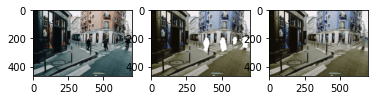

In [17]:
for i, path in enumerate(os.listdir(input_folder)):
    path_img = input_folder + path
#     img = cv2.imread(path_img)
#     print(img.dtype)
    
    #Read_img
    img_input = Image.open(path_img)
    width,height=img_input.size
    
    img_mask, output = test(path_img, input_size, segment_net, device, objects)
    
    #Create_image
    path_img_input = output_folder + path
    path_img_mask = output_folder + os.path.splitext(path)[0] + "_mask" + os.path.splitext(path)[1]
    path_output = output_folder + os.path.splitext(path)[0] + "_result" + os.path.splitext(path)[1]
    
    #Convert_int32_to_uint8
    img_mask = img_mask.detach().numpy().astype(np.uint8)
    output = output.detach().numpy().astype(np.uint8)
    #Resize_image
    img_mask = cv2.resize(img_mask, (width, height), interpolation = cv2.INTER_AREA)
    output = cv2.resize(output, (width, height), interpolation = cv2.INTER_AREA)
    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB)
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    
    img_input.save(path_img_input)
    cv2.imwrite(path_img_mask, img_mask)
    cv2.imwrite(path_output, output)

    plt.subplot(1,3,1)
    plt.imshow(img_input)
    plt.subplot(1,3,2)
    plt.imshow(img_mask)
    plt.subplot(1,3,3)
    plt.imshow(output)
    plt.show()

In [18]:
input_image = "Images/Inputs_1/1.jpg"

In [19]:
img, img_gray, edge, mask = load(input_image, input_size, segment_net, device, objects)

/opt/anaconda3/envs/Object_Removal/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  import sys
/opt/anaconda3/envs/Object_Removal/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  if sys.path[0] == '':
/opt/anaconda3/envs/Object_Removal/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [20]:
images = img.to(config.DEVICE).resize_((1,3, 256, 256))
img_grays = (img_gray.to(config.DEVICE)).resize_((1,1, 256, 256))
edges = (edge.to(config.DEVICE)).resize_((1,1, 256, 256))
masks = (mask.to(config.DEVICE)).resize_((1,1, 256, 256))

In [21]:
edges = edge_model(img_grays, edges, masks)
outputs = inpaint_model(images, edges, masks)
outputs_merged = (outputs * masks) + (images * (1 - masks))

In [22]:
edges_result = postprocess(1 - edges)[0]
masked_result = postprocess(images * (1 - masks) + masks)[0]
output = postprocess(outputs_merged)[0]
print(edges_result.shape)

torch.Size([256, 256, 1])


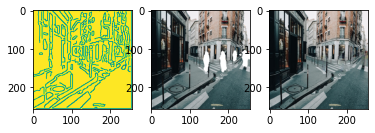

In [23]:
plt.subplot(1,3,1)
plt.imshow(edges_result)
plt.subplot(1,3,2)
plt.imshow(masked_result)
plt.subplot(1,3,3)
plt.imshow(output)
plt.show()